In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator
## EOF 关键包
from eofs.standard import Eof

plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

In [2]:
ds = xr.open_dataset('../../data/sst.mnmean.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2016, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-01-07

# 第一问

In [3]:
Twinter=ds['sst'].loc[ds.time.dt.season.isin(['DJF'])].loc['1855-12':'2021-03']
Twinter

<xarray.DataArray 'sst' (time: 498, lat: 89, lon: 180)>
[7977960 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1855-12-01 1856-01-01 ... 2021-02-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [4]:
lat=Twinter['lat'].data
lon=Twinter['lon'].data
time=pd.date_range('1856','2022',freq='1Y')

In [5]:
sstwin=np.zeros((len(time),len(lat),len(lon)))

In [6]:
count=0
temp=np.zeros((len(lat), len(lon)))
t_i=0
for i in list(Twinter.time.data):
    temp=temp+Twinter.loc[i,:,:]
    count+=1
    if count==3:
        sstwin[t_i,:,:]=temp/3
        count=0
        t_i+=1
        temp=np.zeros((len(lat), len(lon)))

In [7]:
dssstwin=xr.Dataset({'sstwin':(['time','lat','lon'],sstwin)},
                    coords={'lon': (['lon'], lon),
                           'lat': (['lat'], lat),
                           'time': (['time'], time)})

In [8]:
dssstwin

<xarray.Dataset>
Dimensions:  (time: 166, lat: 89, lon: 180)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * time     (time) datetime64[ns] 1856-12-31 1857-12-31 ... 2021-12-31
Data variables:
    sstwin   (time, lat, lon) float64 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

# 第二问

In [9]:
ZDsst=ds['sst'].loc['1948':'2021',30:-30,190:270]
ZDsst

<xarray.DataArray 'sst' (time: 888, lat: 31, lon: 41)>
[1128648 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 30.0 28.0 26.0 24.0 22.0 ... -24.0 -26.0 -28.0 -30.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 264.0 266.0 268.0 270.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [10]:
ZDeof=Eof(np.array(ZDsst))
## 取前2两个模态
eofZD=ZDeof.eofsAsCorrelation(neofs=1) # 空间场
pcZD=ZDeof.pcs(npcs=1,pcscaling=1) # 时间序列
evar=ZDeof.varianceFraction(neigs=1) # 解释方差

In [11]:
lon=ZDsst['lon'].data
lat=ZDsst['lat'].data

In [12]:
# 创建地图
def createmap(ax1,lons,lone,lats,late):
    # 海岸线
    ax1.coastlines('110m')
    ax1.set_extent([lons,lone,lats,late],crs=ccrs.PlateCarree())
    # 标注坐标轴
    ax1.set_xticks(np.arange(lons,lone+10, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(lats,late+10, 10), crs=ccrs.PlateCarree())
    # 设置大小刻度
    minorticks = MultipleLocator(10)
    majorticks = MultipleLocator(30)
    ax1.xaxis.set_major_locator(majorticks)
    ax1.xaxis.set_minor_locator(minorticks)
    ax1.yaxis.set_minor_locator(minorticks)
    # 经纬度格式，把0经度设置不加E和W
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

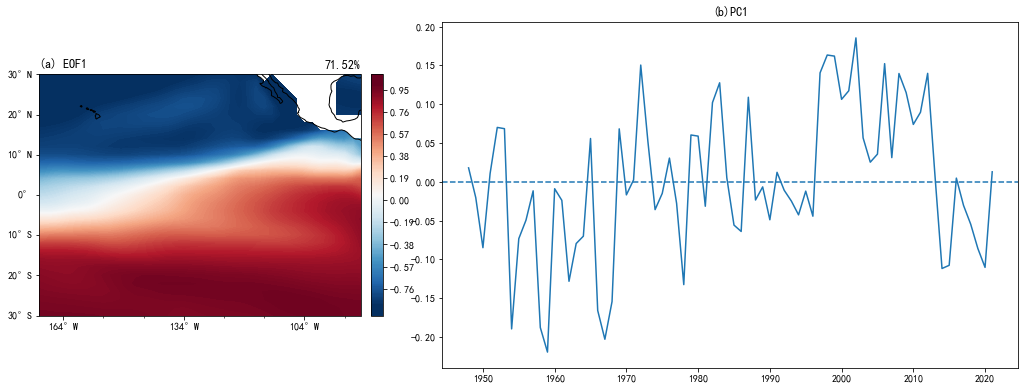

In [13]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_axes([0.1,0.1,0.3,0.8],projection=ccrs.PlateCarree(central_longitude=226))
createmap(ax1,190,270,-30,30)
colorbar=ax1.contourf(lon,lat,eofZD[0,:,:],cmap=plt.cm.RdBu_r,zorder=0,extend='both',levels=np.arange(-0.9,1,0.01),transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', pad=0.03, fraction=0.04, shrink=0.7)
# 设置标题
ax1.set_title('(a) EOF1',loc='left')
ax1.set_title(str(round(evar[0]*100,2))+'%',loc='right')
#-------------------------------------------------------------------#
def smoothyear(pcZD):
    year=np.arange(1948,2022,1)
    pc=np.zeros(len(year))
    count=0
    temp=0
    t_i=0
    for i in range(len(pcZD)):
        temp=temp+pcZD[i,0]
        count+=1
        if count==12:
            pc[t_i]=temp/12
            count=0
            t_i+=1
            temp=0
    return pc,year
pc,year=smoothyear(pcZD)
ax2=fig.add_axes([0.45,0.1,0.5,0.8])
ax2.plot(year,pc)
ax2.axhline(y=0,linestyle='--')
ax2.set_title('(b)PC1')

# 保存图片
plt.savefig('../../picture/Pythonhome/12/ex2.png')

# 第三问

In [14]:
YDsst=ds['sst'].loc['1948':'2021',20:-30,45:120]
YDsst

<xarray.DataArray 'sst' (time: 888, lat: 26, lon: 38)>
[877344 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 20.0 18.0 16.0 14.0 12.0 ... -24.0 -26.0 -28.0 -30.0
  * lon      (lon) float32 46.0 48.0 50.0 52.0 54.0 ... 114.0 116.0 118.0 120.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [15]:
YDeof=Eof(np.array(YDsst))
## 取前2两个模态
eofYD=YDeof.eofsAsCorrelation(neofs=1) # 空间场
pcYD=YDeof.pcs(npcs=1,pcscaling=1) # 时间序列
evarYD=YDeof.varianceFraction(neigs=1) # 解释方差
#-----------------------------------------------#
lon=YDsst['lon'].data
lat=YDsst['lat'].data

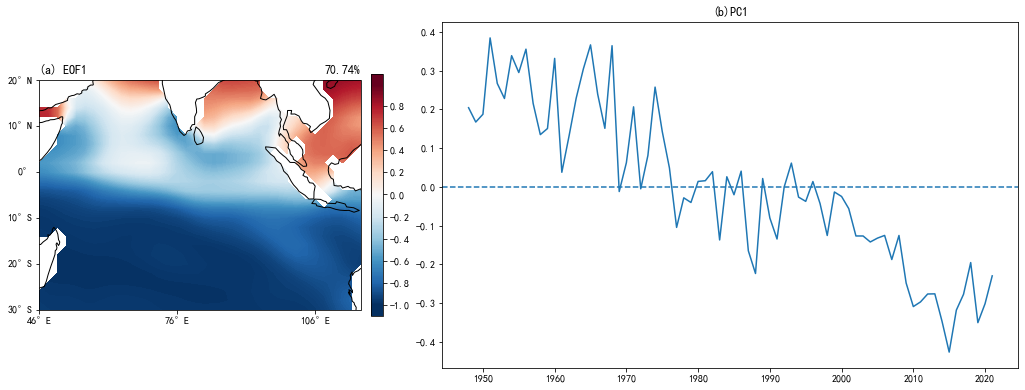

In [16]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_axes([0.1,0.1,0.3,0.8],projection=ccrs.PlateCarree(central_longitude=226))
createmap(ax1,46,110,-30,20)
colorbar=ax1.contourf(lon,lat,eofYD[0,:,:],cmap=plt.cm.RdBu_r,zorder=0,extend='both',levels=np.arange(-1,1,0.01),transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', pad=0.03, fraction=0.04, shrink=0.7)
# 设置标题
ax1.set_title('(a) EOF1',loc='left')
ax1.set_title(str(round(evarYD[0]*100,2))+'%',loc='right')
#-------------------------------------------------------------------#
pc1,year=smoothyear(pcYD)
ax2=fig.add_axes([0.45,0.1,0.5,0.8])
ax2.plot(year,pc1)
ax2.axhline(y=0,linestyle='--')
ax2.set_title('(b)PC1')

# 保存图片
plt.savefig('../../picture/Pythonhome/12/ex3.png')

# 第四问 协方差、相关系数
$r=\frac{\frac{1}{n}\sum_{i=1}^{n}(X_{i}-\overline{X})(Y_{i}-\overline{Y})}{\frac{1}{n}\sqrt{\sum_{i=1}^{n}(X_{i}-\overline{X})^2}\sqrt{\sum_{i=1}^{n}(Y_{i}-\overline{Y})^2}}$
<br>
协方差
$S_{xy}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\overline{x})(y_{i}-\overline{y})$

In [17]:
# 读取温度
airchina=xr.open_dataset('../../data/air.mon.mean.nc')['air'].loc['1948':'2021',55:15,70:135]
airchina

<xarray.DataArray 'air' (time: 888, lat: 17, lon: 27)>
[407592 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 55.0 52.5 50.0 47.5 45.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 70.0 72.5 75.0 77.5 80.0 ... 127.5 130.0 132.5 135.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]

In [18]:
# 求相关系数
def xiangguan(x,ds):
    x=x-x.mean()
    y=ds-ds.mean(dim='time')
    x=x.reshape((len(x),1,1))
    up=np.sum(x*y,axis=0)/len(x)
    down=(np.sqrt(np.sum(x**2))*np.sqrt(np.sum(y**2,axis=0)))/len(x)
    # 相关系数
    r=up/down
    return r
# 求协方差
def xiefang(x,ds):
    x=x-x.mean()
    y=ds-ds.mean(dim='time')
    x=x.reshape((len(x),1,1))
    xie=(y*x).sum(axis=0)/len(x)
    return xie

In [19]:
lat=airchina.lat.data
lon=airchina.lon.data

In [20]:
%%time
#--------------------协方差---------------------#
ZDxie_china=xiefang(pcZD[:,0],airchina)
YDxie_china=xiefang(pcYD[:,0],airchina)
#--------------------相关系数--------------------#
ZDxiang_china=xiangguan(pcZD[:,0],airchina)
YDxiang_china=xiangguan(pcYD[:,0],airchina)

CPU times: total: 297 ms
Wall time: 288 ms


###################################耗时过长####################################################
%%time
ZDxie_china=np.zeros((len(airchina.lat),len(airchina.lon)))
YDxie_china=np.zeros((len(airchina.lat),len(airchina.lon)))
ZDxiang_china=np.zeros((len(airchina.lat),len(airchina.lon)))
YDxiang_china=np.zeros((len(airchina.lat),len(airchina.lon)))
latlist=list(airchina.lat.data)
lonlist=list(airchina.lon.data)
for lat_i in latlist:
    for lon_i in lonlist:
        #-------------------协方差-----------------------#
        ZDxie_china[latlist.index(lat_i),lonlist.index(lon_i)]=np.cov(pcZD[:,0],airchina.loc[:,lat_i,lon_i].data)[0,1]
        YDxie_china[latlist.index(lat_i),lonlist.index(lon_i)]=np.cov(pcYD[:,0],airchina.loc[:,lat_i,lon_i].data)[0,1]
        #--------------------相关系数---------------------#
        ZDxiang_china[latlist.index(lat_i),lonlist.index(lon_i)]=np.corrcoef(pcZD[:,0],airchina.loc[:,lat_i,lon_i].data)[0,1]
        YDxiang_china[latlist.index(lat_i),lonlist.index(lon_i)]=np.corrcoef(pcYD[:,0],airchina.loc[:,lat_i,lon_i].data)[0,1]

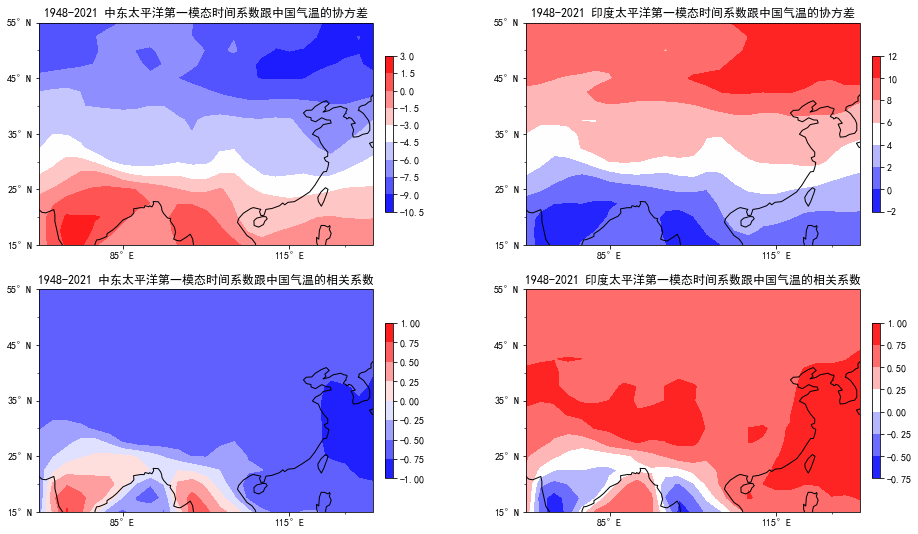

In [21]:
fig=plt.figure(figsize=(16,9))
ax=fig.subplots(2,2,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=115)})
ax1=ax[0,0]
ax2=ax[0,1]
ax3=ax[1,0]
ax4=ax[1,1]
for i in [ax1,ax2,ax3,ax4]:
    createmap(i,70,125,15,55)
#------------------------ZD协方差-----------------------#
colorbar=ax1.contourf(lon,lat,ZDxie_china,cmap='bwr',transform=ccrs.PlateCarree())
plt.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.04, shrink=0.7,ax=ax1)
ax1.set_title('1948-2021 中东太平洋第一模态时间系数跟中国气温的协方差')
#------------------------YD协方差-----------------------#
colorbar=ax2.contourf(lon,lat,YDxie_china,cmap='bwr',transform=ccrs.PlateCarree())
plt.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.04, shrink=0.7,ax=ax2)
ax2.set_title('1948-2021 印度太平洋第一模态时间系数跟中国气温的协方差')
#-------------------------ZD相关系数---------------------#
colorbar=ax3.contourf(lon,lat,ZDxiang_china,cmap='bwr',transform=ccrs.PlateCarree())
plt.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.04, shrink=0.7,ax=ax3)
ax3.set_title('1948-2021 中东太平洋第一模态时间系数跟中国气温的相关系数')
#-------------------------YD相关系数---------------------#
colorbar=ax4.contourf(lon,lat,YDxiang_china,cmap='bwr',transform=ccrs.PlateCarree())
plt.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.04, shrink=0.7,ax=ax4)
ax4.set_title('1948-2021 印度太平洋第一模态时间系数跟中国气温的相关系数')

### 保存图片
plt.savefig('../../picture/Pythonhome/12/ex4.png')

# 第五问

In [22]:
ZDsst

<xarray.DataArray 'sst' (time: 888, lat: 31, lon: 41)>
array([[[18.999987, 18.881481, ..., 18.296137, 19.220795],
        [20.575962, 20.38293 , ..., 20.149712, 21.147705],
        ...,
        [22.792307, 22.598955, ..., 23.20208 , 22.912247],
        [21.744492, 21.573185, ..., 23.058504, 22.840729]],

       [[18.683554, 18.520248, ..., 18.065914, 19.111307],
        [20.264135, 20.062288, ..., 19.958687, 21.090076],
        ...,
        [23.558964, 23.39474 , ..., 23.540627, 23.236948],
        [22.54712 , 22.40247 , ..., 23.375528, 23.12062 ]],

       ...,

       [[24.681038, 24.510618, ..., 22.450792, 22.249113],
        [25.469456, 25.333132, ..., 24.121357, 24.024864],
        ...,
        [22.563692, 22.505722, ..., 19.196037, 18.852955],
        [21.209242, 21.16961 , ..., 18.754726, 18.487478]],

       [[22.0043  , 21.94211 , ..., 20.905008, 20.885063],
        [23.151243, 23.117977, ..., 22.786385, 22.877874],
        ...,
        [23.94654 , 23.83421 , ..., 20.369104, 20.023697],
        [22.77168 , 22.67178 , ..., 20.156498, 19.87732 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 30.0 28.0 26.0 24.0 22.0 ... -24.0 -26.0 -28.0 -30.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 264.0 266.0 268.0 270.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [23]:
airchina['time']=ZDsst['time']

In [24]:
airchina

<xarray.DataArray 'air' (time: 888, lat: 17, lon: 27)>
array([[[-11.106443, -10.504189, ..., -32.511288, -28.634514],
        [-10.710965, -10.459991, ..., -29.579998, -27.843546],
        ...,
        [ 24.483873,  25.349678, ...,  23.959682,  24.41968 ],
        [ 24.88903 ,  26.513866, ...,  25.283545,  25.283556]],

       [[-12.873443, -12.232409, ..., -26.10862 , -23.263449],
        [-12.23241 , -12.239993, ..., -21.616896, -21.184822],
        ...,
        [ 24.530693,  26.177586, ...,  24.401726,  24.332764],
        [ 24.703102,  26.316896, ...,  25.397238,  24.91345 ]],

       ...,

       [[ -7.30501 ,  -6.575844, ..., -16.709177, -13.472514],
        [ -7.52501 ,  -6.977514, ..., -12.451676, -11.879181],
        ...,
        [ 27.876654,  27.005817, ...,  27.268324,  27.422487],
        [ 27.432486,  27.781656, ...,  27.807487,  27.503319]],

       [[-10.886298, -10.002423, ..., -30.638721, -27.683079],
        [-11.255654, -10.657269, ..., -26.111303, -26.38469 ],
        ...,
        [ 25.901602,  26.100792, ...,  25.16854 ,  25.580633],
        [ 26.30725 ,  27.41208 , ...,  26.38063 ,  26.353209]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 55.0 52.5 50.0 47.5 45.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 70.0 72.5 75.0 77.5 80.0 ... 127.5 130.0 132.5 135.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]

In [25]:
from xMCA import xMCA
#--------------------中东太平洋海温和我国气温的svd分析------------#
ZDsvd=xMCA(airchina,ZDsst)
ZDsvd.solver()
lp,rp=ZDsvd.patterns(n=1)
le,re=ZDsvd.expansionCoefs(n=1)
frac=ZDsvd.covFracs(n=1)

In [26]:
lon=lp['lon'].data
lat=lp['lat'].data
lon1=rp['lon'].data
lat1=rp['lat'].data

In [27]:
# 对时间序列求年平均
def smoothsvd(le):
    year=np.arange(1948,2022,1)
    pc=np.zeros(len(year))
    count=0
    temp=0
    t_i=0
    for i in range(len(le[0,:])):
        temp=temp+le[0,i].data
        count+=1
        if count==12:
            pc[t_i]=temp/12
            count=0
            t_i+=1
            temp=0
    return pc,year

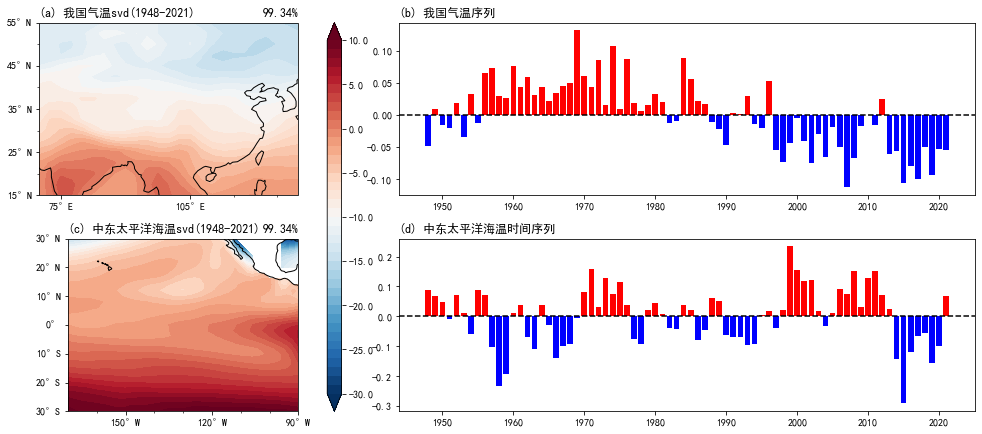

In [28]:
## 绘图部分
fig =plt.figure(figsize=(20,6))
# SVD空间场
ax1=fig.add_axes([0.1,0.55,0.48,0.4],projection=ccrs.PlateCarree(central_longitude=105))
ax3=fig.add_axes([0.1,0.05,0.5,0.4],projection=ccrs.PlateCarree(central_longitude=240))
createmap(ax1,70,125,15,55)
createmap(ax3,190,270,-30,30)
# 设置标题
ax1.set_title('(a) 我国气温svd(1948-2021)',loc='left')
ax1.set_title(str(round(frac[0].data*100,2))+'%',loc='right')
ax3.set_title('(c) 中东太平洋海温svd(1948-2021)',loc='left')
ax3.set_title(str(round(frac[0].data*100,2))+'%',loc='right')
# chinasvd
ax1.contourf(lon,lat,lp[0,:,:],cmap=plt.cm.RdBu_r,zorder=0,extend='both',levels=np.arange(-30,11,1),transform=ccrs.PlateCarree())
# ZDsvd
colorbar=ax3.contourf(lon1,lat1,rp[0,:,:],cmap=plt.cm.RdBu_r,zorder=0,extend='both',levels=np.arange(-30,11,1),transform=ccrs.PlateCarree())
colorbarax=fig.add_axes([0.45,0.05,0.01,0.9])
plt.colorbar(colorbar,cax=colorbarax,format='%.1f',shrink=0.5)
#SVD时间序列
ax2=fig.add_axes([0.5,0.55,0.4,0.4])
ax4=fig.add_axes([0.5,0.05,0.4,0.4])
ax2.set_title('(b) 我国气温序列',loc='left')
ax4.set_title('(d) 中东太平洋海温时间序列',loc='left')
###
le1,year=smoothsvd(le)
bar=ax2.bar(year,le1,color='black')
for i in bar:
    if i.get_height()>0:
        i.set_facecolor('red')
    else:
        i.set_facecolor('blue')
ax2.axhline(y=0,linestyle='--',color='black')
#-----------------------------------------------------------------------------------#
re1,year=smoothsvd(re)
bar=ax4.bar(year,re1,color='black')
for i in bar:
    if i.get_height()>0:
        i.set_facecolor('red')
    else:
        i.set_facecolor('blue')
ax4.axhline(y=0,linestyle='--',color='black')
##保存图片
plt.savefig('../../picture/Pythonhome/12/ex5.png')

In [29]:
#----------------------------印度洋海温和我国气温的svd分析-----------------------#
YDsvd=xMCA(airchina,YDsst)
YDsvd.solver()
lp,rp=YDsvd.patterns(n=1)
leYD,reYD=YDsvd.expansionCoefs(n=1)
frac=YDsvd.covFracs(n=1)

In [30]:
lon=lp['lon'].data
lat=lp['lat'].data
lon1=rp['lon'].data
lat1=rp['lat'].data

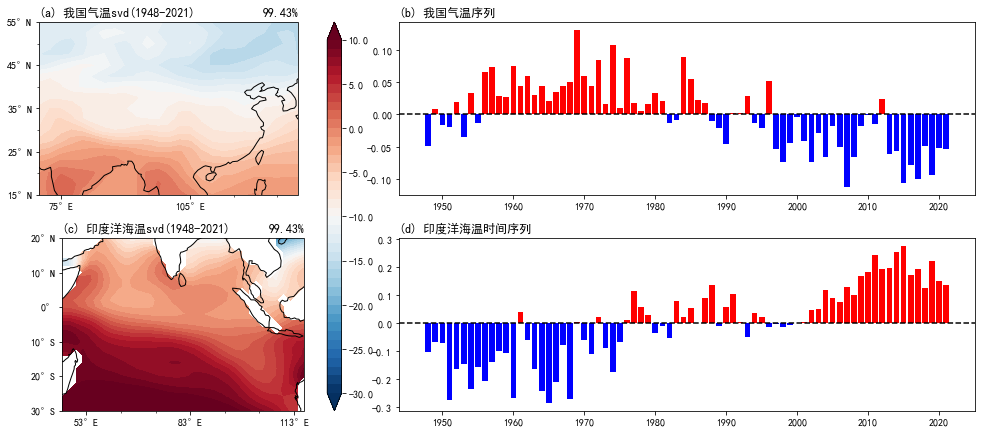

In [31]:
## 绘图部分
fig =plt.figure(figsize=(20,6))
# SVD空间场
ax1=fig.add_axes([0.1,0.55,0.48,0.4],projection=ccrs.PlateCarree(central_longitude=105))
ax3=fig.add_axes([0.1,0.05,0.5,0.4],projection=ccrs.PlateCarree(central_longitude=83))
createmap(ax1,70,125,15,55)
createmap(ax3,46,110,-30,20)
# 设置标题
ax1.set_title('(a) 我国气温svd(1948-2021)',loc='left')
ax1.set_title(str(round(frac[0].data*100,2))+'%',loc='right')
ax3.set_title('(c) 印度洋海温svd(1948-2021)',loc='left')
ax3.set_title(str(round(frac[0].data*100,2))+'%',loc='right')
# chinasvd
ax1.contourf(lon,lat,lp[0,:,:],cmap=plt.cm.RdBu_r,zorder=0,extend='both',levels=np.arange(-30,11,1),transform=ccrs.PlateCarree())
# ZDsvd
colorbar=ax3.contourf(lon1,lat1,rp[0,:,:],cmap=plt.cm.RdBu_r,zorder=0,extend='both',levels=np.arange(-30,11,1),transform=ccrs.PlateCarree())
colorbarax=fig.add_axes([0.45,0.05,0.01,0.9])
plt.colorbar(colorbar,cax=colorbarax,format='%.1f',shrink=0.5)
#SVD时间序列
ax2=fig.add_axes([0.5,0.55,0.4,0.4])
ax4=fig.add_axes([0.5,0.05,0.4,0.4])
ax2.set_title('(b) 我国气温序列',loc='left')
ax4.set_title('(d) 印度洋海温时间序列',loc='left')
###
le1,year=smoothsvd(leYD)
bar=ax2.bar(year,le1,color='black')
for i in bar:
    if i.get_height()>0:
        i.set_facecolor('red')
    else:
        i.set_facecolor('blue')
ax2.axhline(y=0,linestyle='--',color='black')
#-----------------------------------------------------------------------------------#
re1,year=smoothsvd(reYD)
bar=ax4.bar(year,re1,color='black')
for i in bar:
    if i.get_height()>0:
        i.set_facecolor('red')
    else:
        i.set_facecolor('blue')
ax4.axhline(y=0,linestyle='--',color='black')
##保存图片
plt.savefig('../../picture/Pythonhome/12/ex6.png')

 # 第六问

In [32]:
# 对于y= aX1+bX2来说
# 中东太平洋海温和印度洋海温的第一模态的时间系数当作X1，Y1
# 则中国夏季海温为Y 求解出回归系数 a，b   多元回归
#-----------------选出中国夏季气温和时间系数夏季的部分------------------#
airchinasum=airchina.loc[airchina.time.dt.month.isin([6,7,8])]
resum=re[0,:].loc[re.time.dt.month.isin([6,7,8])]
reYDsum=reYD[0,:].loc[reYD.time.dt.month.isin([6,7,8])]

In [33]:
X=np.zeros((len(resum),2))
X[:,0]=resum.data
X[:,1]=reYDsum.data

In [34]:
Y=airchinasum.data

In [35]:
b=np.zeros((2,17,27))
for i in range(17):
    for j in range(27):
        temp=np.dot(np.linalg.inv(X.T.dot(X)),X.T)
        b[:,i,j]=np.dot(temp,Y[:,i,j])

In [36]:
resum

<xarray.DataArray 'rightExpansionCoefs' (time: 222)>
array([-0.30619344, -1.0457968 , -1.2728809 , -0.30895728, -0.9374897 ,
       -1.2658421 , -0.30088934, -0.82086474, -1.1107835 , -0.32044253,
       -1.0049199 , -1.3692237 , -0.28450206, -0.8567748 , -1.2117362 ,
       -0.4282964 , -1.085014  , -1.4068748 , -0.4844414 , -1.0369544 ,
       -1.3070364 , -0.3068242 , -0.8792356 , -1.1557281 , -0.26479954,
       -0.85061115, -1.2566025 , -0.49838805, -1.0579575 , -1.3763396 ,
       -0.5831986 , -1.0656952 , -1.5107518 , -0.5632471 , -1.117295  ,
       -1.4588815 , -0.4673167 , -1.038538  , -1.3912618 , -0.31961957,
       -0.9717505 , -1.3293898 , -0.42012364, -1.0385233 , -1.4428761 ,
       -0.54917103, -1.0030856 , -1.3594949 , -0.35265902, -0.9044527 ,
       -1.2026204 , -0.38036934, -0.9105289 , -1.3205816 , -0.53545195,
       -1.1142288 , -1.4161389 , -0.41959217, -0.99743927, -1.4678909 ,
       -0.54614   , -1.0904751 , -1.4128214 , -0.3791778 , -0.98646873,
       -1.3217164 , -0.37971106, -0.9217302 , -1.2877914 , -0.25125983,
       -0.8366899 , -1.2072453 , -0.22896162, -0.9115278 , -1.3346969 ,
       -0.27935442, -0.8319695 , -1.1561897 , -0.27162844, -0.80447555,
       -1.199861  , -0.25100744, -0.81357   , -1.1103876 , -0.3286106 ,
       -0.9140418 , -1.3378764 , -0.46965116, -1.0730408 , -1.4810629 ,
       -0.37091458, -0.95450914, -1.3665158 , -0.26623303, -0.87762225,
       -1.3262032 , -0.34456792, -0.90577936, -1.2162867 , -0.34775892,
...
       -1.1840292 , -0.46211767, -0.9699686 , -1.370758  , -0.54741436,
       -1.046852  , -1.362644  , -0.56588644, -1.0819968 , -1.3094829 ,
       -0.5909658 , -1.0761638 , -1.4093655 , -0.55777425, -1.115772  ,
       -1.4036974 , -0.40379173, -0.91468525, -1.1870216 , -0.43010712,
       -0.9847185 , -1.3234999 , -0.48681983, -1.1313038 , -1.5372065 ,
       -0.3972044 , -0.925964  , -1.2822559 , -0.11727703, -0.65372455,
       -1.0280427 , -0.31659642, -0.8690922 , -1.2683027 , -0.32219607,
       -0.8701623 , -1.1770196 , -0.27564716, -0.8856361 , -1.2809787 ,
       -0.38210875, -0.9072541 , -1.3044515 , -0.46822652, -1.0487064 ,
       -1.4099733 , -0.47667623, -0.9652399 , -1.335974  , -0.35822785,
       -1.0316038 , -1.3401202 , -0.31729397, -0.8742235 , -1.2594297 ,
       -0.23217277, -0.79293936, -1.1293558 , -0.3854139 , -0.9937175 ,
       -1.3557746 , -0.3090404 , -0.81169236, -1.1098711 , -0.30653498,
       -0.7983621 , -1.1334221 , -0.2594755 , -0.8400097 , -1.2416923 ,
       -0.41528386, -0.97311056, -1.2958498 , -0.52326614, -1.1086522 ,
       -1.5276273 , -0.6369859 , -1.2797099 , -1.7145532 , -0.55626154,
       -1.080611  , -1.3190219 , -0.39797458, -1.0872021 , -1.4239187 ,
       -0.40424576, -1.0033784 , -1.3506713 , -0.5224437 , -1.1770903 ,
       -1.4983455 , -0.5175694 , -1.0855566 , -1.3708183 , -0.37166142,
       -0.8611758 , -1.2353214 ], dtype=float32)
Coordinates:
    n        int32 0
  * time     (time) datetime64[ns] 1948-06-01 1948-07-01 ... 2021-08-01
Attributes:
    long_name:  Time expansion coefficients for sst.

In [37]:
# 回归预测2021年夏季气温
re2021=resum.loc['2021'].data
reYD2021=reYDsum.loc['2021'].data
air2021=np.zeros((3,17,27))
for i in range(3):
    air2021[i,:,:]=b[0,:,:]*re2021[i]+b[1,:,:]* reYD2021[i]
air2021=air2021.mean(axis=0)

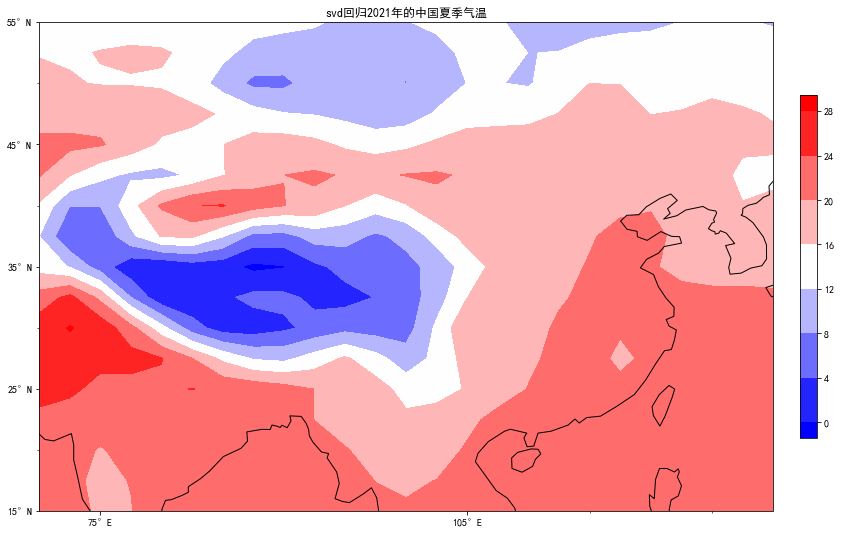

In [38]:
fig=plt.figure(figsize=(16,9))
ax=fig.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=105)})
createmap(ax,70,125,15,55)
ax.set_title('svd回归2021年的中国夏季气温')
colorbar=ax.contourf(lon,lat,air2021[:,:],cmap='bwr',zorder=0,extend='both',transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', pad=0.03, fraction=0.04, shrink=0.7)

# 保存图片
plt.savefig('../../picture/Pythonhome/12/ex7.png')